<img src="https://www.ncei.noaa.gov/themes/custom/ncei/logo.svg" width="800">

## Data from NOAA's National Data Buoy Center (NDBC)

NOAA (National Oceanic and Atmospheric Administration) is the agency of the United States responsible for the collection, storage, and dissemination of oceanograpphic and atmospheric data.

The National Data Buoy Center (NDBC) is a network of buoy stations that monitor the environmental conditions and wave height of the ocean along the coasts of the United States.

Sources:
- https://www.ncei.noaa.gov/access/metadata/landing-page/bin/iso?id=gov.noaa.nodc:NDBC-CMANWx
- https://www.ndbc.noaa.gov/data/historical/stdmet/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os, glob

from IPython.display import display

from spatial_interpolation import data
from spatial_interpolation.pipelines.noaa import metadata_extraction as noaa_metadata
from spatial_interpolation.visualization import map_viz

%matplotlib inline

Number of individual buoy stations: 68
Number of files available for the corresponding stations: 969
Average available buoys at a time: 20.0


,filename,Last modified,Size,buoy_id,year,buoy_name,latitude,longitude
124,41001h1976.txt.gz,1998-08-12 19:30:00,18K,41001,1976,41001 150 NM East of Cape HATTERAS,34.724,-72.317
125,41001h1977.txt.gz,1998-08-12 19:30:00,28K,41001,1977,41001 150 NM East of Cape HATTERAS,34.724,-72.317
126,41001h1978.txt.gz,1998-08-12 19:30:00,31K,41001,1978,41001 150 NM East of Cape HATTERAS,34.724,-72.317
127,41001h1979.txt.gz,1998-08-12 19:30:00,14K,41001,1979,41001 150 NM East of Cape HATTERAS,34.724,-72.317
128,41001h1980.txt.gz,1998-08-12 19:30:00,43K,41001,1980,41001 150 NM East of Cape HATTERAS,34.724,-72.317


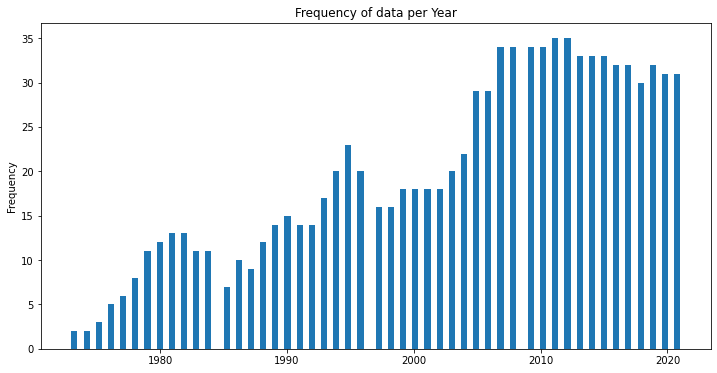

In [53]:
# https://www.ndbc.noaa.gov/data/historical/stdmet/
stmed_data_index_html = open("references/stdmet_data_index.html").read()
buoy_locations_info_df = pd.read_csv("data/02_interim/buoy_locations.csv")

data_index_df = noaa_metadata.get_buoy_stdmet_index_df(stmed_data_index_html)
metadata_df = noaa_metadata.make_ndbc_metadata_df(buoy_locations_info_df, data_index_df)
# metadata_df = metadata_df[metadata_df.year>=2011]
print("Number of individual buoy stations:", metadata_df.buoy_id.nunique())
print("Number of files available for the corresponding stations:",len(metadata_df.filename.unique()))
print("Average available buoys at a time:",metadata_df.groupby("year").buoy_id.nunique().mean().round())
display(metadata_df.head())
metadata_df.year.plot(kind="hist",title="Frequency of data per Year",bins=100, figsize=(12,6));

In [3]:
import folium
from functools import partial
map_viz.make_map_of_buoys(
    location = (26.382792, -82.192264),
    buoy_locations_df=buoy_locations_info_df, 
    marker=partial(folium.CircleMarker, radius=1, weight=5,color="black")
)

In [ ]:
# Write the filenames to a txt file to later wget them
url_template = "https://www.ndbc.noaa.gov/data/historical/stdmet/{filename}"
data_urls = [url_template.format(filename=f) for f in metadata_df.filename.unique()]
with open("../references/ndbc_stdmet_buoy_data_urls.txt","w") as f:
    f.write("\n".join(data_urls))

---------

### Data Description

| Field | Description |
| --- | --- |
| YY | Year |
| MM | Month |
| DD | Day |
| hh | Hour |
| mm | Minute |
| WDIR | Wind direction (the direction the wind is coming from in degrees clockwise from true N) |
| WSPD | Wind speed, averaged over an eight-minute period (m/s) |
| GST | Peak 5 or 8 second gust speed measured during the eight-minute or two-minute period(m/s) |
| WVHT | Significant wave height (meters) |
| DPD | Dominant wave period (seconds) |
| APD | Average wave period (seconds) |
| MWD | The direction from which the waves at the dominant period (DPD) are coming. The units are degrees from true North, increasing clockwise, with North as 0 (zero) degrees and East as 90 degrees. |
| PRES | Sea level pressure (hPa) |
| ATMP | Air temperature (Celsius) |
| WTMP | Sea surface temperature (Celsius) |
| DEWP | Dewpoint temperature (Celsius) |
| VIS | visibility (nautical miles) |
| TIDE | Water level in feet above or below Mean Lower Low Water, MLLW (feet) |
    
Source: https://mgimond.github.io/ES218/Week02d.html

In [7]:
from spatial_interpolation.pipelines.noaa import data_processing as dp
from spatial_interpolation.pipelines.noaa.utils.datasets import RawBuoyDataSet

import logging
logging.basicConfig()
raw_files = glob.glob("data/01_raw/ndbc_stdmet_buoy_data/*.txt.gz")[-2:-1]
raw_df = RawBuoyDataSet(raw_files[0]).load()
processed_df = dp.process_raw_stdmet_df(raw_df.drop(columns=["VIS","GST","TIDE","APD","PRES"]))
# parsed_dfs = dp.parse_raw_buoy_files(raw_files, num_cores=3)
# parsed_dfs[0]
# WDIR WSPD WVHT DPD MWD ATMP WTMP DEWP
processed_df.columns = processed_df.columns\
    .str.replace("temperature","temp")\
        .str.replace("direction","dir")\
        .str.replace("dominant_","")
display(
    processed_df.head()
    .round(1)
    .head()
    # .loc[:,["YY", "MM", "DD", "hh", "mm", "WDIR", "WSPD", "WVHT", "DPD", "MWD", "ATMP"]]
    .loc[:,["time","buoy_id","wind_dir","wind_speed","wave_height","wave_period"]]
    # .to_latex(index=False)
)
# print(
#     raw_df

# )


,time,buoy_id,wind_dir,wind_speed,wave_height,wave_period
0,2016-12-31 23:50:00,41008,50.0,3.7,0.3,10.0
1,2017-01-01 00:50:00,41008,67.0,2.5,0.3,9.1
2,2017-01-01 01:50:00,41008,55.0,2.6,0.3,10.8
3,2017-01-01 02:50:00,41008,30.0,1.9,0.4,11.4
4,2017-01-01 03:50:00,41008,103.0,2.8,0.4,10.0


----

### Buoys available in time

In [59]:
# ndbc_data = data.NDBCDataLoader().load()#start="2011-01-01", end="2022-01-01").load()
ndbc_data = ndbc_data.join(resample="7D").dropna(subset=["geometry"])
# ndbc_gdf.plot(figsize=(12,6))
map_viz.heatmap_with_time(ndbc_data.sort_index(level="time"), "time", zoom_start=4)

/export/usuarios01/ssviloria/ml-spatial-interpolation/src/spatial_interpolation/visualization/map_viz.py:193: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mp = make_folium_map(gdf.dissolve().centroid.iloc[0],**map_args)
/export/usuarios01/ssviloria/ml-spatial-interpolation/src/spatial_interpolation/visualization/map_viz.py:195: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroids"] = gdf.geometry.centroid


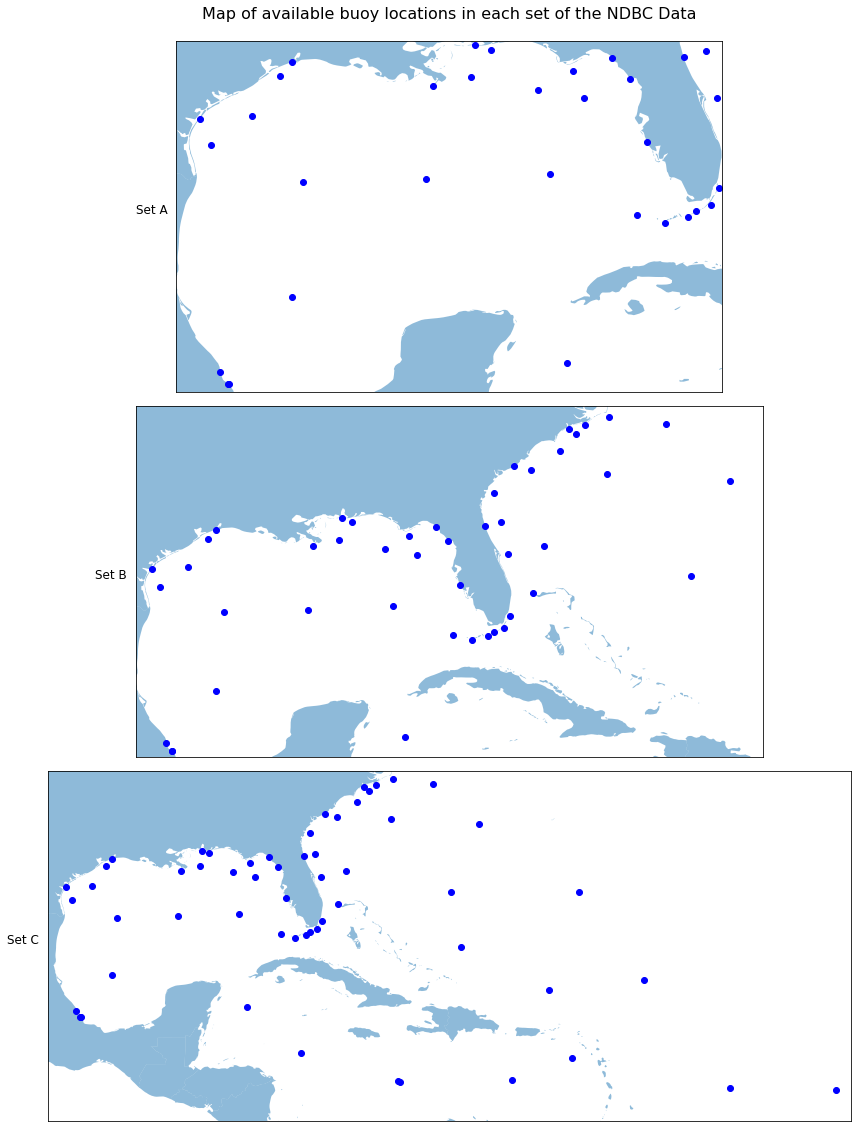

In [65]:
## visualize each sets (A, B, C)
from experiments.evaluation import eval_sets
from subplotted import subplotted

# load data
ndbc_gdf = data.load_buoys_geo()
ndbc_geo = ndbc_gdf.loc[2010:2021].groupby("buoy_id").first()
# ndbc_geo = ndbc_geo[ndbc_geo.index.isin(ndbc_gdf.index.get_level_values("buoy_id").unique())]
df_countries = data.load_world_borders()

# fig, axes = plt.subplots(len(eval_sets.ndbc), 1, figsize=(12,16))
for S, ax, (i, set_conf) in subplotted(enumerate(eval_sets.ndbc.values()), ncols=1, figsize=(12,16), facecolor="white"):
    set_geo =  ndbc_geo.loc[ndbc_geo.within(set_conf.area)]
    set_letter = chr(ord("A")+i)
    xmin, ymin, xmax, ymax = set_conf.area.bounds
    df_countries.plot(ax=ax, alpha=0.5)
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    set_geo.plot(ax=ax, color="blue")
    ax.set_ylabel(f"Set {set_letter}", rotation=0, fontsize=12, labelpad=25)
    ax.set_xticks([]); ax.set_yticks([])
else:
    S.fig.suptitle("Map of available buoy locations in each set of the NDBC Data", fontsize=16)
    S.fig.tight_layout()
    # accomodate to give margin for the title
    S.fig.subplots_adjust(top=0.95)
    # S.fig.savefig("reports/figures/ndbc_buoy_sets.png", dpi=300, bbox_inches="tight")

In [97]:
for S, ax, (i,set_conf) in subplotted(enumerate(eval_sets.ndbc.values()), ncols=3, figsize=(16,8), facecolor="white", sharey=True):
    set_geo =  ndbc_gdf.loc[ndbc_gdf.within(set_conf.area)]
    set_geo.index\
        .get_level_values("year")\
        .to_series()\
        .plot(ax=ax, kind="hist",title="Set {}".format(chr(ord("A")+i)), bins=100)
    ax.set_ylim(0,60)
else:
    # S.fig.suptitle("Frequency of data per year in each set of the NDBC Data", fontsize=16)
    S.fig.tight_layout()
    # S.fig.subplots_adjust(top=0.92)
    # S.set_all(ylabel="", yticklabels=[], indices=[1,2])
    S.fig.savefig("reports/figures/ndbc_buoy_sets_year.png", dpi=300, bbox_inches="tight")

-------

### Analysis of Spatial Variance

In [4]:
import gstools as gs
import pandas as pd
from pandas import IndexSlice as idx
from spatial_interpolation import data

import matplotlib.pyplot as plt


In [5]:
# get the data
df, gdf = data.load_buoy_data(period=("2010-01-01", "2022-01-01"))
# pick a time
time = "2021-01-01 00:00:00"
xyz = (
    df
    .loc[idx[:, time], :]
    .join(gdf.loc[pd.Timestamp(time).year])
    .loc[:, ["longitude","latitude", "wave_height","geometry"]]
    .dropna()
)

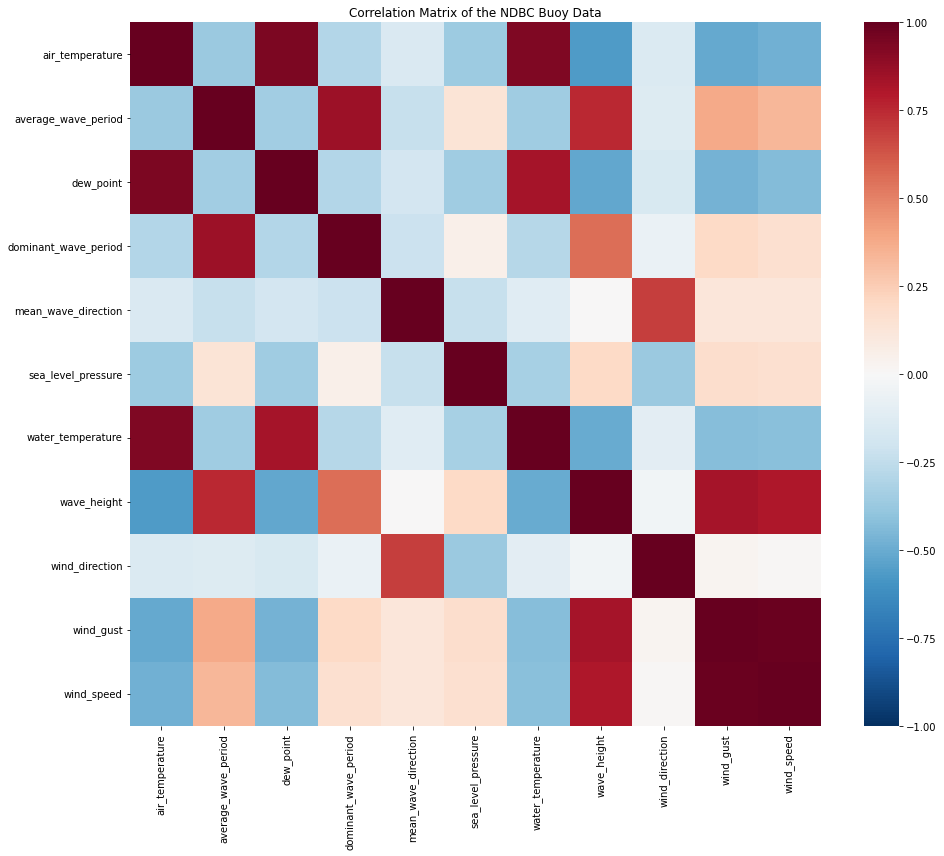

In [10]:
import seaborn as sns
# plot correlation matrix
fig, ax = plt.subplots(figsize=(14,12), facecolor="w")
ax = sns.heatmap(
    df
    .groupby("time")
    .mean()
    .dropna(how="all",axis=1)
    .dropna()
    .sort_index()
    .corr("pearson"),
    cmap="RdBu_r",
    ax=ax,
    vmin=-1,
    vmax=1,
)
ax.set_title("Correlation Matrix of the NDBC Buoy Data")
fig.tight_layout()
fig.savefig("reports/figures/ndbc_corr_matrix.png", dpi=300)

In [108]:
(df
    .groupby("time")
    .mean()
    .dropna(how="all",axis=1)
    .dropna()
)

,air_temperature,average_wave_period,dew_point,dominant_wave_period,mean_wave_direction,sea_level_pressure,water_temperature,wave_height,wind_direction,wind_gust,wind_speed
time,,,,,,,,,,,
2010-01-01 00:00:00,20.726087,5.512708,16.416667,8.627826,128.818182,1019.268750,22.454167,1.719565,173.608696,6.538000,5.296000
2010-01-01 01:00:00,20.717391,5.501458,16.530000,8.722609,136.909091,1019.439583,22.412500,1.737609,179.413043,6.126000,4.864000
2010-01-01 02:00:00,20.639130,5.501667,16.803333,8.714130,130.727273,1019.420833,22.387500,1.678913,192.260870,6.384000,5.132000
2010-01-01 03:00:00,20.918182,5.277045,17.114286,8.050952,129.363636,1019.017391,22.452174,1.485000,188.159091,6.579167,5.156250
2010-01-01 04:00:00,20.595652,5.346522,16.420000,8.212500,145.545455,1018.937500,22.337500,1.604318,186.369565,7.564000,5.840000
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,23.376000,5.250833,21.452500,8.415833,151.875000,1014.941667,23.987302,1.236667,174.174242,6.833333,5.386538
2021-12-31 20:00:00,23.496933,5.274583,21.587500,8.520417,140.708333,1014.757639,24.001587,1.222917,175.500000,6.835897,5.378846
2021-12-31 21:00:00,23.651333,5.290000,21.372222,8.510833,138.083333,1014.781944,24.020635,1.218333,173.878788,6.984615,5.523718


In [94]:
(
    df
    .groupby("time")
    .mean()
    .dropna(how="all",axis=1)
    .dropna()
)


,air_temperature,average_wave_period,dew_point,dominant_wave_period,mean_wave_direction,sea_level_pressure,water_temperature,wave_height,wind_direction,wind_gust,wind_speed
time,,,,,,,,,,,
2010-01-01 00:00:00,20.726087,5.512708,16.416667,8.627826,128.818182,1019.268750,22.454167,1.719565,173.608696,6.538000,5.296000
2010-01-01 01:00:00,20.717391,5.501458,16.530000,8.722609,136.909091,1019.439583,22.412500,1.737609,179.413043,6.126000,4.864000
2010-01-01 02:00:00,20.639130,5.501667,16.803333,8.714130,130.727273,1019.420833,22.387500,1.678913,192.260870,6.384000,5.132000
2010-01-01 03:00:00,20.918182,5.277045,17.114286,8.050952,129.363636,1019.017391,22.452174,1.485000,188.159091,6.579167,5.156250
2010-01-01 04:00:00,20.595652,5.346522,16.420000,8.212500,145.545455,1018.937500,22.337500,1.604318,186.369565,7.564000,5.840000
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 19:00:00,23.376000,5.250833,21.452500,8.415833,151.875000,1014.941667,23.987302,1.236667,174.174242,6.833333,5.386538
2021-12-31 20:00:00,23.496933,5.274583,21.587500,8.520417,140.708333,1014.757639,24.001587,1.222917,175.500000,6.835897,5.378846
2021-12-31 21:00:00,23.651333,5.290000,21.372222,8.510833,138.083333,1014.781944,24.020635,1.218333,173.878788,6.984615,5.523718


Estimate the variogram of the field with 40 bins and plot the result.

estimated bin number: 10
maximal bin distance: 9.5
RANKING by Pseudo-r2 score
     1.          Matern: 0.7999
     2.        Gaussian: 0.7999
     3.         JBessel: 0.7998


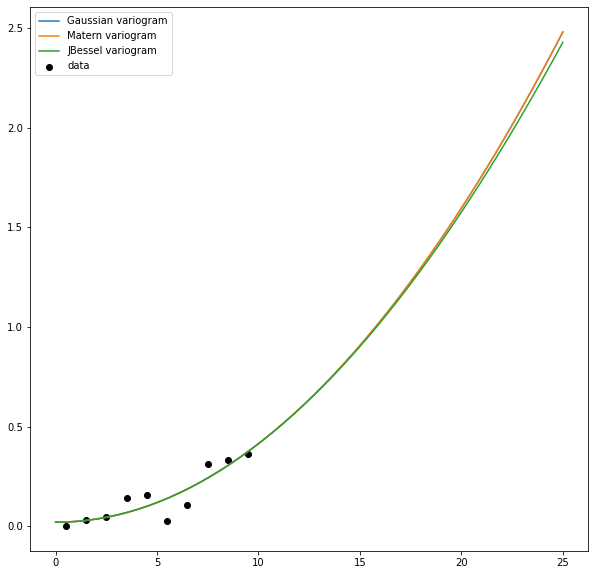

In [57]:
# Set of models to test.
models = {
    "Gaussian": gs.Gaussian,
    # "Exponential": gs.Exponential,
    "Matern": gs.Matern,
    # "Stable": gs.Stable,
    # "Rational": gs.Rational,
    # "Circular": gs.Circular,
    # "Spherical": gs.Spherical,
    # "SuperSpherical": gs.SuperSpherical,
    "JBessel": gs.JBessel,
}
scores = {}
# get the parameters of the field
bins = np.arange(11)
bin_center, gamma = gs.vario_estimate((xyz.longitude, xyz.latitude),xyz.wave_height, bins)
print("estimated bin number:", len(bin_center))
print("maximal bin distance:", max(bin_center))
# Iterate over all models, fit their variogram and calculate the r2 score.
# plot the estimated variogram
plt.figure(figsize=(10, 10))
plt.scatter(bin_center, gamma, color="k", label="data")
ax = plt.gca()

# fit all models to the estimated variogram
for model in models:
    fit_model = models[model](dim=2)
    para, pcov, r2 = fit_model.fit_variogram(bin_center, gamma, return_r2=True)
    fit_model.plot(x_max=25, ax=ax)
    scores[model] = r2
ranking = sorted(scores.items(), key=lambda item: item[1], reverse=True)
print("RANKING by Pseudo-r2 score")
for i, (model, score) in enumerate(ranking, 1):
    print(f"{i:>6}. {model:>15}: {score:.5}")

plt.show()

nbins: 10
RMSE: 0.169


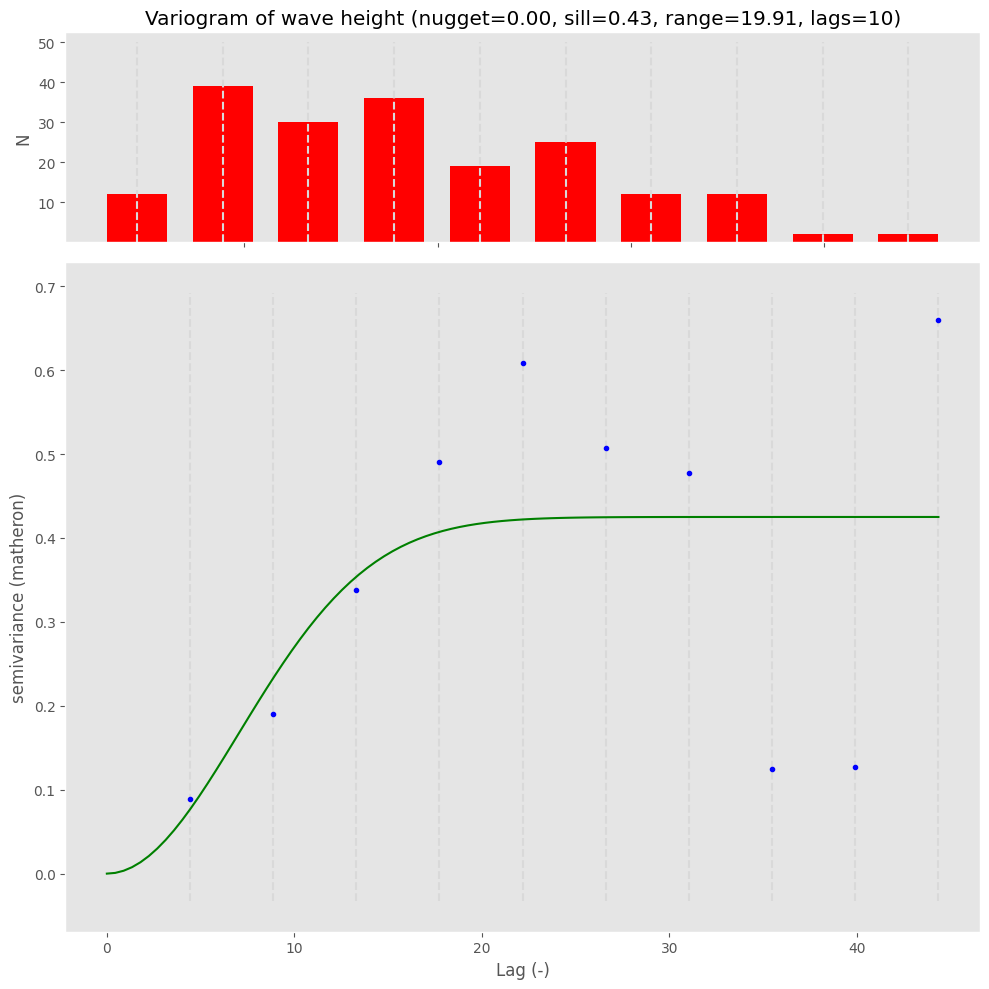

In [166]:
import skgstat as skg
# skg.plotting.backend('matplotlib')
plt.style.use("ggplot") # or for a more traditional style, "fivethirtyeight"
V = skg.Variogram(xyz[["longitude","latitude"]], xyz.wave_height)
V.model = "gaussian"
mosaic = """
AAA
BBB
BBB
BBB
"""
fig, ax_dict = plt.subplot_mosaic(mosaic, figsize=(10, 10))
axes = list(ax_dict.values())[::-1]
V.plot(axes=axes)
# adjust size
print(f"nbins: {V.n_lags}")
print(f"RMSE: {V.rmse:.3f}")
fig.set_size_inches(10, 10)
variogram_desc = V.describe()

axes[-1].set_title(f"Variogram of wave height (nugget={variogram_desc['nugget']:.2f}, sill={variogram_desc['sill']:.2f}, range={variogram_desc['effective_range']:.2f}, lags={variogram_desc['params']['n_lags']})")
# axes[0].set_xlabel("Distance")
fig.tight_layout();

In [82]:
import json
with open('references/tereno.json', 'r') as js:
    data_obj = json.load(js)
coords = np.array(data_obj['coordinates'])
vals = np.array(data_obj['values'])
print(data_obj['description'])
STV = skg.SpaceTimeVariogram(coords, vals[:,::3], x_lags=20, t_lags=20, model='product-sum')

print(STV)

Data derived from Fersch et al. (2020) https://doi.org/10.5194/essd-2020-48. Published under CC BY 4.0.
 It is  From the WSN product, the T_a in 20cm depth is extracted


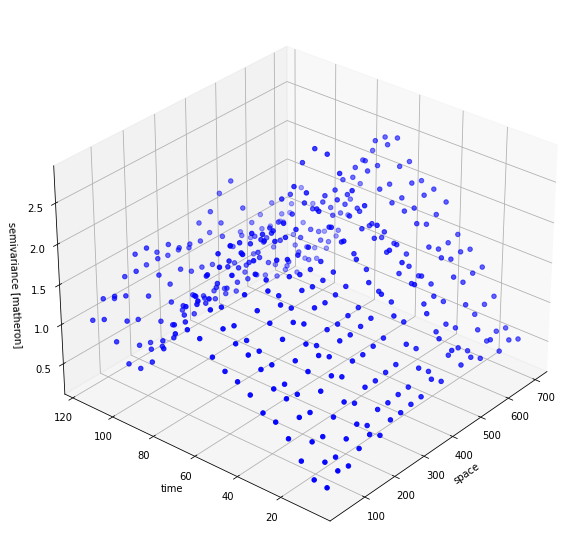

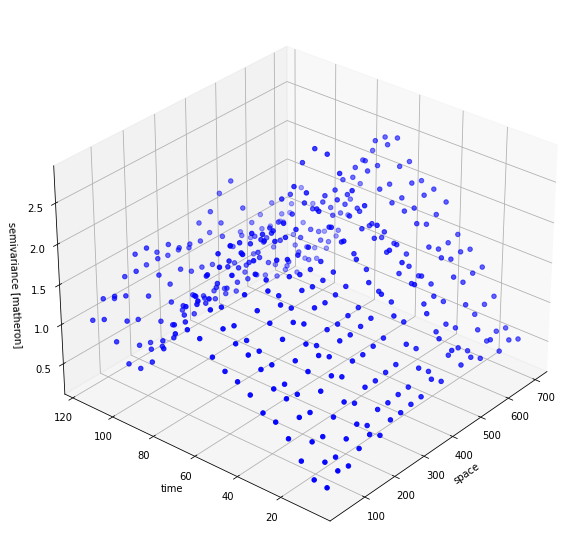

In [83]:
fig = STV.plot(kind='scatter', no_model=True, show=False)
fig

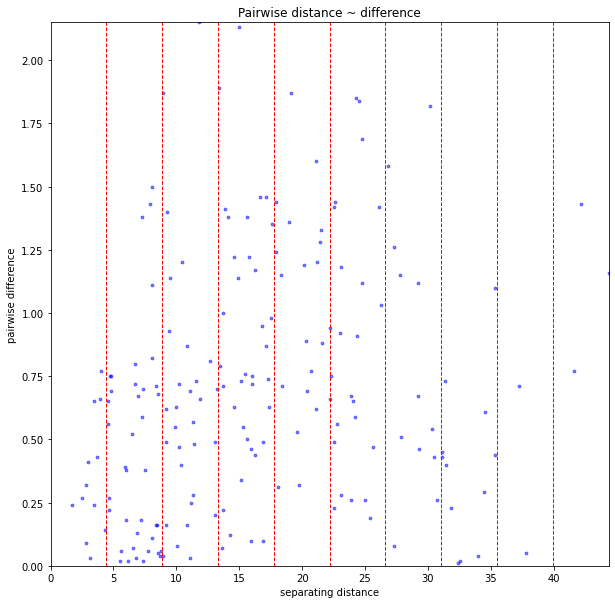

In [46]:
fig = V.distance_difference_plot()
fig.set_size_inches(10, 10)
